## Learn model
## Content
  * Load data
  * Select features
  * Learning
    * linear
    * lasso
    * ridge
    * elastic net
    * Xgboost
    * MLP
  * Compare results

In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from pymongo import MongoClient
import warnings
import sklearn.linear_model as linear_model
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
MONGODB_URL = os.environ['MONGODB_URI']
client = MongoClient(MONGODB_URL)
db = client.get_default_database()

In [3]:
data = db["notebook"].find({})
full_frame = pd.DataFrame(list(data))
full_frame.drop(columns=["_id"], inplace=True)
full_frame.shape

(2928, 79)

### Select features

In [4]:
features = [
    'Neighborhood',
    'GarageFinish',
    'Foundation',
    'MasVnrType',
    'GarageType',
    'MSSubClass',
    'GrLivArea',
    'TotalBsmtSF',
    'GarageCars',
    'BsmtQual',
    'YearBuilt',
    'YearRemodAdd',
    'FireplaceQu',
    'FullBath',
    'BsmtFinSF1',
    'MasVnrArea']

to_log_transform = ['GrLivArea', 'TotalBsmtSF', 'MasVnrArea', 'BsmtFinSF1']

to_pow_transform = ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'Neighborhood', 'GrLivArea']

to_boolean_transform = {
    'TotalBsmtSF': {'new_feature_name': 'HasBasement', 'threshold': 0},
    'GarageArea': {'new_feature_name': 'HasGarage', 'threshold': 0},
    '2ndFlrSF': {'new_feature_name': 'Has2ndFloor', 'threshold': 0},
    'MasVnrArea': {'new_feature_name': 'HasMasVnr', 'threshold': 0},
    'WoodDeckSF': {'new_feature_name': 'HasWoodDeck', 'threshold': 0},
    'OpenPorchSF': {'new_feature_name': 'HasPorch', 'threshold': 0},
    'PoolArea': {'new_feature_name': 'HasPool', 'threshold': 0},
    'YearBuilt': {'new_feature_name': 'IsNew', 'threshold': 2000},
}

## Learn model

In [5]:
def log_transformation(frame, feature):
    new_feature_name = new_log_feature_name(feature)
    frame[new_feature_name] = np.log1p(frame[feature].values)

def new_quadratic_feature_name(feature):
    return feature+'2'

def new_log_feature_name(feature):
    return feature+'Log'
    
def quadratic(frame, feature):
    new_feature_name = new_quadratic_feature_name(feature)
    frame[new_feature_name] = frame[feature]**2
    
def boolean_transformation(frame, feature, new_feature_name, threshold):
    frame[new_feature_name] = frame[feature].apply(lambda x: 1 if x > threshold else 0)
    
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def error_mse(actual, predicted):
    actual = (actual)
    predicted = (predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

In [6]:
added_boolean_columns = [
    'HasBasement', 
    'HasGarage', 
    'Has2ndFloor', 
    'HasMasVnr', 
    'HasWoodDeck',
    'HasPorch', 
    'HasPool', 
    'IsNew']

added_quadratic_columns = list(map(new_quadratic_feature_name, to_pow_transform))

added_log_columns = list(map(new_log_feature_name, to_log_transform))

def transform_before_learn(frame, to_log_transform, to_pow_transform, to_boolean_transform):

    for c in to_log_transform:
        log_transformation(frame, c)

    for c in to_pow_transform:
        quadratic(frame, c)

    for c in to_boolean_transform.keys():
        boolean_transformation(frame, c, to_boolean_transform[c]['new_feature_name'], 
                               to_boolean_transform[c]['threshold']) 


transform_before_learn(full_frame, to_log_transform, to_pow_transform, to_boolean_transform)

df_train = full_frame[:1460]
df_test = full_frame[1460:]

In [7]:
features_full_list = features + added_boolean_columns + added_quadratic_columns + added_log_columns

## Out liars

In [8]:
df_train_cleaned = df_train
#df_train_cleaned = df_train.drop(df_train[df_train['Id'] == 1299].index)
#df_train_cleaned = df_train.drop(df_train[df_train['Id'] == 524].index)

### LinearRegression

In [9]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

linear = linear_model.LinearRegression()
linear.fit(X, np.log1p(Y))

Ypred_linear = np.expm1(linear.predict(full_X))
print(error(full_Y, Ypred_linear))
print(error_mse(full_Y, Ypred_linear))

0.14350553665809343
28409.372376053554


#### test dataset

In [10]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(linear.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.1572632283139389
26215.797935890478


### LassoCV

In [11]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

lasso = linear_model.LassoCV()
lasso.fit(X, np.log1p(Y))

Ypred_lasso = np.expm1(lasso.predict(full_X))
print(error(full_Y, Ypred_lasso))
print(error_mse(full_Y, Ypred_linear))

0.24221631303400099
28409.372376053554


#### test dataset

In [12]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(lasso.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.2422063181996949
47414.119621120786


### RidgeCV

In [13]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

ridge = linear_model.RidgeCV()
ridge.fit(X, np.log1p(Y))
Ypred_ridge = np.expm1(ridge.predict(full_X))
print(error(full_Y,Ypred_ridge))
print(error_mse(full_Y, Ypred_ridge))

0.22325121591333777
49752.73335593299


#### test dataset

In [14]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(ridge.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.19930383529788964
41291.4927524926


### ElasticNetCV

In [15]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

elasticNet = linear_model.ElasticNetCV()
elasticNet.fit(X, np.log1p(Y))
Ypred_elasticNet = np.expm1(elasticNet.predict(full_X))
print(error(full_Y,Ypred_elasticNet))
print(error_mse(full_Y, Ypred_elasticNet))

0.2422163132230314
78156.03507810256


#### test dataset

In [16]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(elasticNet.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.24220631862484118
47414.11977487526


### Xgboost

In [17]:
import xgboost as xgb

In [18]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

In [19]:
dtrain = xgb.DMatrix(X, label = np.log(Y))

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

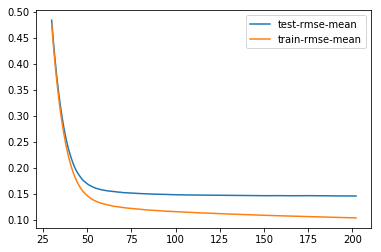

In [20]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [21]:
X_tr, X_val, y_tr, y_val = train_test_split(X, np.log1p(Y), random_state = 42, test_size=0.20)

eval_set = [(X_val, y_val)]

In [22]:
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_tr, y_tr, eval_metric="rmse", early_stopping_rounds=500, eval_set=eval_set, verbose=True)
# model_xgb.fit(X, np.log1p(Y))

[0]	validation_0-rmse:10.3548
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:9.31671
[2]	validation_0-rmse:8.38255
[3]	validation_0-rmse:7.5463
[4]	validation_0-rmse:6.7915
[5]	validation_0-rmse:6.11422
[6]	validation_0-rmse:5.50272
[7]	validation_0-rmse:4.95413
[8]	validation_0-rmse:4.45872
[9]	validation_0-rmse:4.01307
[10]	validation_0-rmse:3.61238
[11]	validation_0-rmse:3.25175
[12]	validation_0-rmse:2.92664
[13]	validation_0-rmse:2.6336
[14]	validation_0-rmse:2.37059
[15]	validation_0-rmse:2.13545
[16]	validation_0-rmse:1.92325
[17]	validation_0-rmse:1.73222
[18]	validation_0-rmse:1.56111
[19]	validation_0-rmse:1.40508
[20]	validation_0-rmse:1.26612
[21]	validation_0-rmse:1.14132
[22]	validation_0-rmse:1.02856
[23]	validation_0-rmse:0.928054
[24]	validation_0-rmse:0.838128
[25]	validation_0-rmse:0.756725
[26]	validation_0-rmse:0.683733
[27]	validation_0-rmse:0.617998
[28]	validation_0-rmse:0.559514
[29]	validation_0-rmse:0.507401
[30]	valid

[252]	validation_0-rmse:0.138747
[253]	validation_0-rmse:0.138747
[254]	validation_0-rmse:0.138746
[255]	validation_0-rmse:0.138933
[256]	validation_0-rmse:0.138997
[257]	validation_0-rmse:0.138984
[258]	validation_0-rmse:0.138986
[259]	validation_0-rmse:0.138907
[260]	validation_0-rmse:0.13888
[261]	validation_0-rmse:0.138824
[262]	validation_0-rmse:0.138833
[263]	validation_0-rmse:0.139171
[264]	validation_0-rmse:0.139195
[265]	validation_0-rmse:0.139233
[266]	validation_0-rmse:0.139244
[267]	validation_0-rmse:0.139159
[268]	validation_0-rmse:0.139197
[269]	validation_0-rmse:0.139205
[270]	validation_0-rmse:0.139241
[271]	validation_0-rmse:0.139237
[272]	validation_0-rmse:0.139268
[273]	validation_0-rmse:0.139243
[274]	validation_0-rmse:0.139279
[275]	validation_0-rmse:0.139251
[276]	validation_0-rmse:0.139246
[277]	validation_0-rmse:0.139219
[278]	validation_0-rmse:0.139296
[279]	validation_0-rmse:0.139297
[280]	validation_0-rmse:0.139314
[281]	validation_0-rmse:0.139289
[282]	valid

[502]	validation_0-rmse:0.140301
[503]	validation_0-rmse:0.140313
[504]	validation_0-rmse:0.140338
[505]	validation_0-rmse:0.140343
[506]	validation_0-rmse:0.140364
[507]	validation_0-rmse:0.1403
[508]	validation_0-rmse:0.140313
[509]	validation_0-rmse:0.140301
[510]	validation_0-rmse:0.140309
[511]	validation_0-rmse:0.140239
[512]	validation_0-rmse:0.140218
[513]	validation_0-rmse:0.140238
[514]	validation_0-rmse:0.140364
[515]	validation_0-rmse:0.140337
[516]	validation_0-rmse:0.14029
[517]	validation_0-rmse:0.140254
[518]	validation_0-rmse:0.14017
[519]	validation_0-rmse:0.140196
[520]	validation_0-rmse:0.1402
[521]	validation_0-rmse:0.140185
[522]	validation_0-rmse:0.140223
[523]	validation_0-rmse:0.14031
[524]	validation_0-rmse:0.140397
[525]	validation_0-rmse:0.140427
[526]	validation_0-rmse:0.140452
[527]	validation_0-rmse:0.140448
[528]	validation_0-rmse:0.140453
[529]	validation_0-rmse:0.140458
[530]	validation_0-rmse:0.140447
[531]	validation_0-rmse:0.14048
[532]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
Ypred_xgb = np.expm1(model_xgb.predict(full_X))
print(error(full_Y, Ypred_xgb))
print(error_mse(full_Y, Ypred_xgb))

0.09455873766448827
18652.37414655679


#### test dataset

In [24]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(model_xgb.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.15669669841517272
24714.182776707265


## MLP

In [25]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint 
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from keras import backend as K
from keras import losses

Using TensorFlow backend.


In [26]:
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(42)
np.random.seed(42)

In [27]:
mlp_feed = df_train[features]

In [28]:
scaler = StandardScaler()
scaler.fit(mlp_feed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
X_train = scaler.transform(mlp_feed)

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, np.log(Y), random_state = 3, test_size=0.20)

In [31]:
model = Sequential()
model.add(Dense(10, input_dim = X_train.shape[1],  activation="relu"))
model.add(Dense(10, input_dim = X_train.shape[1],  activation="relu"))
model.add(Dense(1))

adam = optimizers.Adam()

model.compile(loss = losses.mean_squared_error, optimizer = adam)

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [33]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)  # save best model

In [34]:
hist = model.fit(X_tr, y_tr, batch_size=1, validation_data = (X_val, y_val), callbacks=[monitor, checkpointer], verbose=1, epochs=50)

Train on 1168 samples, validate on 292 samples
Epoch 1/50
1168/1168 [==============================] - 6s 5ms/step - loss: 34.8748 - val_loss: 5.8946
Epoch 2/50
1168/1168 [==============================] - 5s 4ms/step - loss: 3.3382 - val_loss: 1.8291
Epoch 3/50
1168/1168 [==============================] - 5s 5ms/step - loss: 1.3755 - val_loss: 1.0809
Epoch 4/50
1168/1168 [==============================] - 6s 5ms/step - loss: 0.7691 - val_loss: 0.6168
Epoch 5/50
1168/1168 [==============================] - 6s 5ms/step - loss: 0.4684 - val_loss: 0.3651
Epoch 6/50
1168/1168 [==============================] - 5s 5ms/step - loss: 0.2764 - val_loss: 0.2299
Epoch 7/50
1168/1168 [==============================] - 4s 4ms/step - loss: 0.1827 - val_loss: 0.1632
Epoch 8/50
1168/1168 [==============================] - 5s 4ms/step - loss: 0.1289 - val_loss: 0.1145
Epoch 9/50
1168/1168 [==============================] - 6s 5ms/step - loss: 0.0947 - val_loss: 0.0708
Epoch 10/50
1168/1168 [===========

In [35]:
model.load_weights('best_weights.hdf5')  # load weights from best model

# Measure accuracy
to_predict = scaler.transform(mlp_feed)
Ypred_mlp = np.exp(model.predict(to_predict))
print(error(df_train['SalePrice'].values,Ypred_mlp))
print(error_mse(df_train['SalePrice'].values, Ypred_mlp))

20.59228792131303
4118187.0589269493


#### test dataset

In [36]:
full_test_X = df_test[features]
test_Y = df_test['SalePrice'].values

test_pred = np.exp(model.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

inf
inf


## Compare results

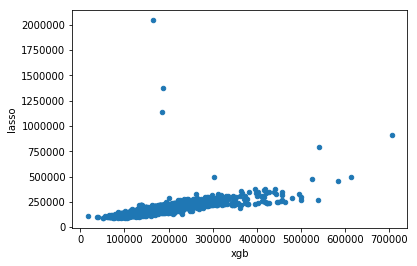

In [37]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "lasso":Ypred_lasso})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

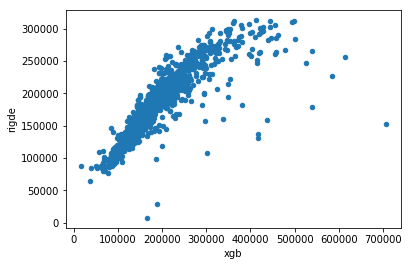

In [39]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "rigde":Ypred_ridge})
predictions.plot(x = "xgb", y = "rigde", kind = "scatter")

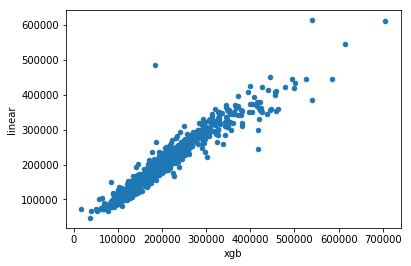

In [40]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "linear":Ypred_linear})
predictions.plot(x = "xgb", y = "linear", kind = "scatter")